In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from scipy.sparse import csr_matrix

import sys

sys.path.insert(0, './code')
import dataloader
import trainer
import numpy as np

In [2]:
import importlib

loader = dataloader.DataLoader()
importlib.reload(trainer)
amt_handler = trainer.AmtTrainHandler()
profile_handler = trainer.AmtProfileHandler()
cnt_handler = trainer.CntTrainHandler()
region_handler = trainer.RegionTrainHandler()


In [3]:
region_feats = loader.load_result(
    '2021_12_23_region_feats.joblib').sort_values(by='chid').reset_index(
        drop=True)
region_handler.update_data(region_feats)
region_train = region_handler.train.reset_index(drop=True)
region_test = region_handler.test.reset_index(drop=True)

Start Update Data
Start Processing train set
Start Processing test set
Finished Update Data


In [4]:
profile_feats = loader.load_result("2021_12_17_light_profile_feats.joblib")
amt_feats = loader.load_result('2021_12_06_amt_feats.joblib')
cnt_feats = loader.load_result('2021_12_15_cnt_feats.joblib')
amt_feats = amt_feats.astype(np.int64)


In [5]:
non_imp_cates = [
    x for x in amt_handler.shop_cate if x not in amt_handler.ylabels
]
amt_drop_feats = []
cnt_drop_feats = []
for dt in range(2, 19):
    for non_imp_cate in non_imp_cates:
        amt_cate_col = "shop_{}_amt_{}".format(non_imp_cate, dt - 24)
        cnt_cate_col = "shop_{}_cnt_{}".format(non_imp_cate, dt - 24)
        amt_drop_feats.append(amt_cate_col)
        cnt_drop_feats.append(cnt_cate_col)

In [6]:
cnt_handler.update_data(cnt_feats)
cnt_handler.train = cnt_handler.train.reset_index(drop=True)
cnt_handler.test = cnt_handler.test.reset_index(drop=True)
cnt_handler.train = cnt_handler.train.drop(cnt_drop_feats, axis=1)
cnt_handler.test = cnt_handler.test.drop(cnt_drop_feats, axis=1)

Start Update Data
Start Processing y label
Start Processing train set
Start Processing test set
Finished updating data


In [7]:
cnt_train = cnt_handler.train.copy()
cnt_test = cnt_handler.test.copy()
cnt_test['dt'] = 25
cnt_train['dt'] = [23] * 500000 + [24] * 500000
ylabels = cnt_handler.y.copy()

In [9]:
amt_handler.update_data(amt_feats)
amt_handler.X = amt_handler.X.drop(amt_drop_feats, axis=1)
amt_handler.test = amt_handler.test.drop(amt_drop_feats, axis=1)
amt_test = amt_handler.test.copy()
amt_train = amt_handler.X.copy()

Start Update Data
Finished updating data


In [10]:
amt_train = amt_train.reset_index(drop=True)
amt_test = amt_test.reset_index(drop=True)

cnt_train = cnt_train.reset_index(drop=True)
cnt_test = cnt_test.reset_index(drop=True)

In [11]:
profile_handler.update_data(profile_feats)
cnt_train = pd.merge(cnt_train, profile_feats, on=['chid', 'dt'], how='left')
cnt_test = pd.merge(cnt_test, profile_feats, on=['chid', 'dt'], how='left')

Start Update Data
Finished updating data
start label encoding
Finish labor encoding


In [12]:
cnt_train = profile_handler.transform(cnt_train)
cnt_test = profile_handler.transform(cnt_test)

In [13]:
import gc

del amt_feats
del cnt_feats
del profile_feats
del region_feats

gc.collect()

0

In [14]:
cnt_train

,chid,shop_2_cnt_-22,shop_6_cnt_-22,shop_10_cnt_-22,shop_12_cnt_-22,shop_13_cnt_-22,shop_15_cnt_-22,shop_18_cnt_-22,shop_19_cnt_-22,shop_21_cnt_-22,...,masts,educd,trdtp,naty,poscd,cuorg,primary_card,slam,age,gender_code
0,10000000,0,0,3,1,0,0,0,0,0,...,2,2,2,1,3,29,1,79557.742574,4,2
1,10000001,1,0,0,0,0,1,1,0,0,...,2,4,11,1,3,29,1,62730.806297,5,1
2,10000002,0,0,0,0,0,0,0,0,0,...,2,4,15,1,11,29,1,79291.240239,3,1
3,10000003,0,0,0,0,0,0,0,0,0,...,2,6,15,1,11,29,1,68561.179121,6,1
4,10000004,0,0,0,0,0,0,0,0,0,...,2,5,15,1,11,29,1,48209.277501,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,10499995,0,0,0,0,0,0,0,0,0,...,1,3,5,1,11,29,1,87397.101503,4,2
999996,10499996,0,0,0,0,0,0,0,0,0,...,2,3,11,1,2,29,1,53339.928323,3,2
999997,10499997,2,0,0,0,0,0,0,0,0,...,1,6,8,1,2,29,1,62730.806297,3,1
999998,10499998,0,0,4,0,0,0,0,1,1,...,2,6,15,1,11,29,1,48209.277501,4,2


In [16]:
cnt_train = cnt_train.drop(['chid', 'dt'], axis=1)
cnt_test = cnt_test.drop(['chid', 'dt'], axis=1)

amt_train = amt_train.drop(['chid'], axis=1)
amt_test = amt_test.drop(['chid'], axis=1)

region_train = region_train.drop(['chid'], axis=1)
region_test = region_test.drop(['chid'], axis=1)

In [17]:
cnt_train = pd.concat([cnt_train, amt_train], axis=1)
cnt_test = pd.concat([cnt_test, amt_test], axis=1)

In [18]:
cnt_train = pd.concat([cnt_train, region_train], axis=1)
cnt_test = pd.concat([cnt_test, region_test], axis=1)

In [19]:
_,_, idx_results = loader.load_result('2021_12_20_amt_train_results.joblib')

In [20]:
seed = 29

params = {
    'learning_rate': 0.01,
    'lambda_l1': 0.0009782288206799821,
    'lambda_l2': 0.00021248013254914345,
    'num_leaves': 1500,
    'feature_fraction': 0.25633622082985474,
    'feature_fraction_bynode': 0.8,
    'bagging_fraction': 0.8504557457590274,
    'bagging_freq': 16,
    'min_child_samples': 500,
    'max_depth': 20,
    'seed': seed,
    'feature_fraction_seed': seed,
    'bagging_seed': seed,
    'drop_seed': seed,
    'data_random_seed': seed,
    'objective': 'tweedie',
    'metric': 'l2',
    'boosting': 'gbdt',
    'verbosity': -1,
    'n_jobs': -1,
}


In [21]:
X = cnt_train.copy()
y = ylabels.reset_index(drop=True).copy()

In [24]:
for col in y.columns:
    y[col] = y[col].apply(lambda x: x if x>0 else 0)

Training fold 1
Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.0717	valid_1's l2: 2.13585
[100]	training's l2: 1.83868	valid_1's l2: 1.90732
[150]	training's l2: 1.62649	valid_1's l2: 1.70197
[200]	training's l2: 1.45759	valid_1's l2: 1.5424
[250]	training's l2: 1.33812	valid_1's l2: 1.43475
[300]	training's l2: 1.26007	valid_1's l2: 1.37081
[350]	training's l2: 1.2102	valid_1's l2: 1.33616
[400]	training's l2: 1.17543	valid_1's l2: 1.31698
[450]	training's l2: 1.14897	valid_1's l2: 1.30626
[500]	training's l2: 1.12776	valid_1's l2: 1.30046
[550]	training's l2: 1.10961	valid_1's l2: 1.29765
[600]	training's l2: 1.09342	valid_1's l2: 1.29578
[650]	training's l2: 1.07895	valid_1's l2: 1.29446
[700]	training's l2: 1.06607	valid_1's l2: 1.2931
[750]	training's l2: 1.05443	valid_1's l2: 1.29219
[800]	training's l2: 1.0422	valid_1's l2: 1.29161
[850]	training's l2: 1.03142	valid_1's l2: 1.2915
[900]	training's l2: 1.02115	valid_1's l2: 1.29149
[950]	train

<Figure size 864x432 with 0 Axes>

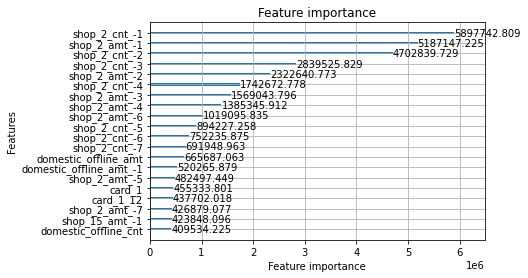

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.128571	valid_1's l2: 0.136449
[100]	training's l2: 0.117216	valid_1's l2: 0.125557
[150]	training's l2: 0.105083	valid_1's l2: 0.113892
[200]	training's l2: 0.0951397	valid_1's l2: 0.104513
[250]	training's l2: 0.087639	valid_1's l2: 0.0976036
[300]	training's l2: 0.0826007	valid_1's l2: 0.0931821
[350]	training's l2: 0.0794206	valid_1's l2: 0.0907441
[400]	training's l2: 0.0772191	valid_1's l2: 0.0893724
[450]	training's l2: 0.0755925	valid_1's l2: 0.0885847
[500]	training's l2: 0.0742307	valid_1's l2: 0.0881404
[550]	training's l2: 0.0728825	valid_1's l2: 0.0878644
[600]	training's l2: 0.0717125	valid_1's l2: 0.0876769
[650]	training's l2: 0.0706637	valid_1's l2: 0.0875865
[700]	training's l2: 0.0697417	valid_1's l2: 0.0875663
[750]	training's l2: 0.0687135	valid_1's l2: 0.0875243
[800]	training's l2: 0.0676937	valid_1's l2: 0.087464
[850]	training's l2: 0.0668049	valid_1's l2: 0.0874774
[900]	trainin

<Figure size 864x432 with 0 Axes>

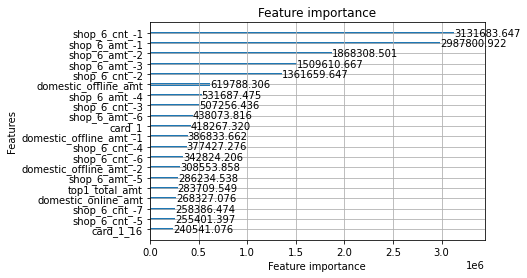

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 10.3885	valid_1's l2: 7.54882
[100]	training's l2: 9.77094	valid_1's l2: 6.96016
[150]	training's l2: 9.08262	valid_1's l2: 6.3154
[200]	training's l2: 8.4184	valid_1's l2: 5.719
[250]	training's l2: 7.84808	valid_1's l2: 5.21696
[300]	training's l2: 7.42346	valid_1's l2: 4.86767
[350]	training's l2: 7.09759	valid_1's l2: 4.63698
[400]	training's l2: 6.84228	valid_1's l2: 4.49794
[450]	training's l2: 6.6148	valid_1's l2: 4.4071
[500]	training's l2: 6.41226	valid_1's l2: 4.3433
[550]	training's l2: 6.21711	valid_1's l2: 4.29856
[600]	training's l2: 6.02568	valid_1's l2: 4.27104
[650]	training's l2: 5.8679	valid_1's l2: 4.24982
[700]	training's l2: 5.67523	valid_1's l2: 4.23039
[750]	training's l2: 5.49178	valid_1's l2: 4.21822
[800]	training's l2: 5.29522	valid_1's l2: 4.20965
[850]	training's l2: 5.16332	valid_1's l2: 4.20368
[900]	training's l2: 4.96761	valid_1's l2: 4.19839
[950]	training's l2: 4.82477	

<Figure size 864x432 with 0 Axes>

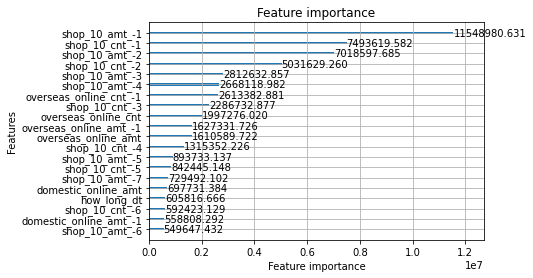

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.270202	valid_1's l2: 0.238569
[100]	training's l2: 0.242352	valid_1's l2: 0.212371
[150]	training's l2: 0.217977	valid_1's l2: 0.190126
[200]	training's l2: 0.199036	valid_1's l2: 0.17364
[250]	training's l2: 0.185695	valid_1's l2: 0.16281
[300]	training's l2: 0.176762	valid_1's l2: 0.156478
[350]	training's l2: 0.170442	valid_1's l2: 0.152667
[400]	training's l2: 0.16579	valid_1's l2: 0.150611
[450]	training's l2: 0.162106	valid_1's l2: 0.149529
[500]	training's l2: 0.157775	valid_1's l2: 0.148375
[550]	training's l2: 0.153678	valid_1's l2: 0.147696
[600]	training's l2: 0.150413	valid_1's l2: 0.147223
[650]	training's l2: 0.146539	valid_1's l2: 0.146827
[700]	training's l2: 0.143634	valid_1's l2: 0.146713
[750]	training's l2: 0.140741	valid_1's l2: 0.14667
[800]	training's l2: 0.137984	valid_1's l2: 0.146707
Early stopping, best iteration is:
[721]	training's l2: 0.142262	valid_1's l2: 0.146565


<Figure size 864x432 with 0 Axes>

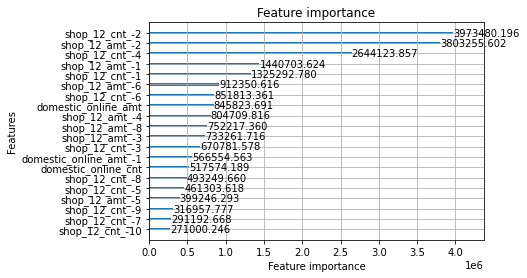

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 3.81804	valid_1's l2: 3.94409
[100]	training's l2: 3.46813	valid_1's l2: 3.59959
[150]	training's l2: 3.05486	valid_1's l2: 3.19421
[200]	training's l2: 2.63883	valid_1's l2: 2.78683
[250]	training's l2: 2.29022	valid_1's l2: 2.44902
[300]	training's l2: 2.04371	valid_1's l2: 2.2181
[350]	training's l2: 1.85648	valid_1's l2: 2.05013
[400]	training's l2: 1.72173	valid_1's l2: 1.94388
[450]	training's l2: 1.61965	valid_1's l2: 1.87244
[500]	training's l2: 1.53769	valid_1's l2: 1.82439
[550]	training's l2: 1.45585	valid_1's l2: 1.78521
[600]	training's l2: 1.3896	valid_1's l2: 1.75582
[650]	training's l2: 1.33186	valid_1's l2: 1.73323
[700]	training's l2: 1.27977	valid_1's l2: 1.71778
[750]	training's l2: 1.23567	valid_1's l2: 1.7044
[800]	training's l2: 1.19338	valid_1's l2: 1.69401
[850]	training's l2: 1.15749	valid_1's l2: 1.69048
[900]	training's l2: 1.12403	valid_1's l2: 1.68694
[950]	training's l2: 1.0

<Figure size 864x432 with 0 Axes>

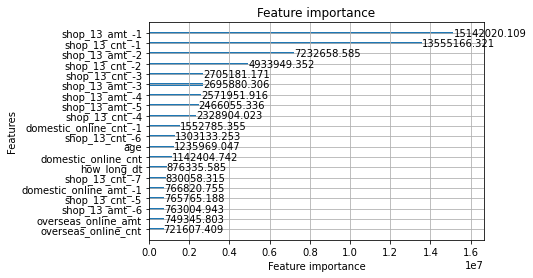

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 5.33625	valid_1's l2: 5.39106
[100]	training's l2: 4.53244	valid_1's l2: 4.61232
[150]	training's l2: 3.81312	valid_1's l2: 3.92394
[200]	training's l2: 3.22589	valid_1's l2: 3.36958
[250]	training's l2: 2.84457	valid_1's l2: 3.02536
[300]	training's l2: 2.59305	valid_1's l2: 2.81025
[350]	training's l2: 2.42719	valid_1's l2: 2.68172
[400]	training's l2: 2.31051	valid_1's l2: 2.59921
[450]	training's l2: 2.22123	valid_1's l2: 2.5423
[500]	training's l2: 2.1558	valid_1's l2: 2.50789
[550]	training's l2: 2.10064	valid_1's l2: 2.48211
[600]	training's l2: 2.05177	valid_1's l2: 2.46235
[650]	training's l2: 2.00968	valid_1's l2: 2.44704
[700]	training's l2: 1.97207	valid_1's l2: 2.43335
[750]	training's l2: 1.93679	valid_1's l2: 2.42354
[800]	training's l2: 1.90575	valid_1's l2: 2.41698
[850]	training's l2: 1.87844	valid_1's l2: 2.41207
[900]	training's l2: 1.85197	valid_1's l2: 2.4094
[950]	training's l2: 1.8

<Figure size 864x432 with 0 Axes>

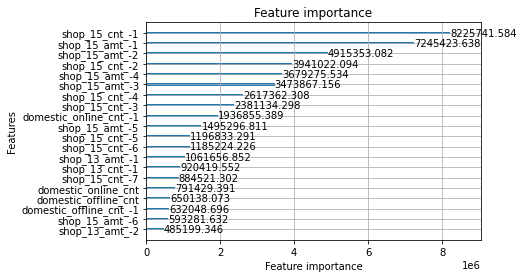

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.157098	valid_1's l2: 0.180104
[100]	training's l2: 0.148843	valid_1's l2: 0.172378
[150]	training's l2: 0.140417	valid_1's l2: 0.164455
[200]	training's l2: 0.13288	valid_1's l2: 0.157481
[250]	training's l2: 0.12689	valid_1's l2: 0.15219
[300]	training's l2: 0.122055	valid_1's l2: 0.148103
[350]	training's l2: 0.118227	valid_1's l2: 0.145109
[400]	training's l2: 0.115067	valid_1's l2: 0.142818
[450]	training's l2: 0.112534	valid_1's l2: 0.141496
[500]	training's l2: 0.110305	valid_1's l2: 0.140414
[550]	training's l2: 0.108412	valid_1's l2: 0.139859
[600]	training's l2: 0.106456	valid_1's l2: 0.139095
[650]	training's l2: 0.104814	valid_1's l2: 0.138918
[700]	training's l2: 0.103072	valid_1's l2: 0.138352
[750]	training's l2: 0.101513	valid_1's l2: 0.137979
[800]	training's l2: 0.10001	valid_1's l2: 0.137759
[850]	training's l2: 0.0988846	valid_1's l2: 0.137678
[900]	training's l2: 0.0977245	valid_1's 

<Figure size 864x432 with 0 Axes>

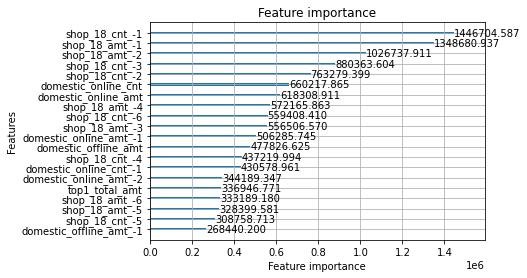

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.262592	valid_1's l2: 0.239855
[100]	training's l2: 0.249651	valid_1's l2: 0.228778
[150]	training's l2: 0.23853	valid_1's l2: 0.219908
[200]	training's l2: 0.229501	valid_1's l2: 0.213426
[250]	training's l2: 0.222578	valid_1's l2: 0.20915
[300]	training's l2: 0.217069	valid_1's l2: 0.206392
[350]	training's l2: 0.21245	valid_1's l2: 0.204706
[400]	training's l2: 0.208547	valid_1's l2: 0.203692
[450]	training's l2: 0.20509	valid_1's l2: 0.203128
[500]	training's l2: 0.20189	valid_1's l2: 0.202744
[550]	training's l2: 0.199079	valid_1's l2: 0.202515
[600]	training's l2: 0.196151	valid_1's l2: 0.202254
[650]	training's l2: 0.193761	valid_1's l2: 0.202211
[700]	training's l2: 0.191055	valid_1's l2: 0.202102
[750]	training's l2: 0.188583	valid_1's l2: 0.202086
[800]	training's l2: 0.186266	valid_1's l2: 0.2021
Early stopping, best iteration is:
[734]	training's l2: 0.189406	valid_1's l2: 0.202062


<Figure size 864x432 with 0 Axes>

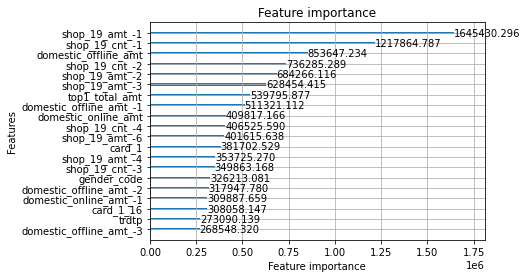

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.211093	valid_1's l2: 0.22145
[100]	training's l2: 0.203051	valid_1's l2: 0.214787
[150]	training's l2: 0.195564	valid_1's l2: 0.2091
[200]	training's l2: 0.1887	valid_1's l2: 0.204413
[250]	training's l2: 0.18274	valid_1's l2: 0.200806
[300]	training's l2: 0.177781	valid_1's l2: 0.198287
[350]	training's l2: 0.173639	valid_1's l2: 0.196547
[400]	training's l2: 0.170065	valid_1's l2: 0.195343
[450]	training's l2: 0.166971	valid_1's l2: 0.194598
[500]	training's l2: 0.164031	valid_1's l2: 0.193989
[550]	training's l2: 0.161233	valid_1's l2: 0.193613
[600]	training's l2: 0.158704	valid_1's l2: 0.193352
[650]	training's l2: 0.156216	valid_1's l2: 0.193057
[700]	training's l2: 0.15423	valid_1's l2: 0.192835
[750]	training's l2: 0.152014	valid_1's l2: 0.192644
[800]	training's l2: 0.149991	valid_1's l2: 0.192526
[850]	training's l2: 0.148226	valid_1's l2: 0.192474
[900]	training's l2: 0.146224	valid_1's l2: 0

<Figure size 864x432 with 0 Axes>

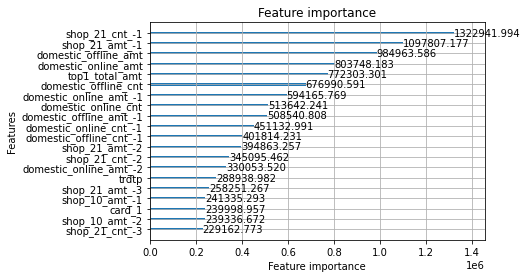

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.170238	valid_1's l2: 0.179687
[100]	training's l2: 0.160905	valid_1's l2: 0.171167
[150]	training's l2: 0.150472	valid_1's l2: 0.161881
[200]	training's l2: 0.139961	valid_1's l2: 0.15278
[250]	training's l2: 0.130776	valid_1's l2: 0.145156
[300]	training's l2: 0.123532	valid_1's l2: 0.139448
[350]	training's l2: 0.118211	valid_1's l2: 0.135662
[400]	training's l2: 0.114293	valid_1's l2: 0.13324
[450]	training's l2: 0.111225	valid_1's l2: 0.131676
[500]	training's l2: 0.108701	valid_1's l2: 0.130882
[550]	training's l2: 0.106348	valid_1's l2: 0.130274
[600]	training's l2: 0.104262	valid_1's l2: 0.129922
[650]	training's l2: 0.102236	valid_1's l2: 0.129638
[700]	training's l2: 0.100499	valid_1's l2: 0.129485
[750]	training's l2: 0.0988872	valid_1's l2: 0.129202
[800]	training's l2: 0.0971971	valid_1's l2: 0.128934
[850]	training's l2: 0.0956623	valid_1's l2: 0.128791
[900]	training's l2: 0.0942434	valid_

<Figure size 864x432 with 0 Axes>

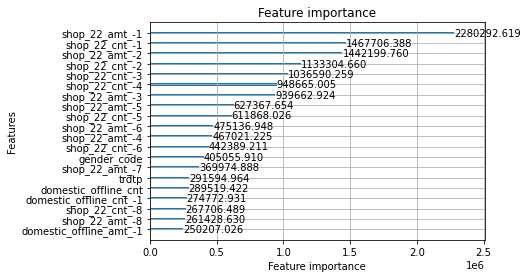

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.225332	valid_1's l2: 0.239661
[100]	training's l2: 0.212212	valid_1's l2: 0.22793
[150]	training's l2: 0.199176	valid_1's l2: 0.216754
[200]	training's l2: 0.187224	valid_1's l2: 0.206908
[250]	training's l2: 0.177849	valid_1's l2: 0.199807
[300]	training's l2: 0.170584	valid_1's l2: 0.194715
[350]	training's l2: 0.16521	valid_1's l2: 0.19143
[400]	training's l2: 0.160786	valid_1's l2: 0.188915
[450]	training's l2: 0.15712	valid_1's l2: 0.187279
[500]	training's l2: 0.153794	valid_1's l2: 0.186196
[550]	training's l2: 0.151081	valid_1's l2: 0.18567
[600]	training's l2: 0.148072	valid_1's l2: 0.184699
[650]	training's l2: 0.145214	valid_1's l2: 0.183898
[700]	training's l2: 0.142741	valid_1's l2: 0.183578
[750]	training's l2: 0.140454	valid_1's l2: 0.183148
[800]	training's l2: 0.13804	valid_1's l2: 0.182483
[850]	training's l2: 0.135953	valid_1's l2: 0.182263
[900]	training's l2: 0.134007	valid_1's l2: 

<Figure size 864x432 with 0 Axes>

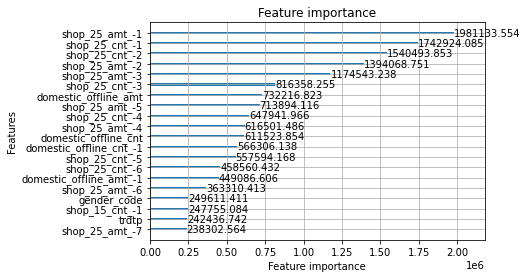

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.125562	valid_1's l2: 0.130496
[100]	training's l2: 0.119034	valid_1's l2: 0.124523
[150]	training's l2: 0.111694	valid_1's l2: 0.117877
[200]	training's l2: 0.104751	valid_1's l2: 0.1118
[250]	training's l2: 0.0986391	valid_1's l2: 0.106617
[300]	training's l2: 0.0941097	valid_1's l2: 0.10316
[350]	training's l2: 0.0907201	valid_1's l2: 0.100927
[400]	training's l2: 0.088101	valid_1's l2: 0.0996227
[450]	training's l2: 0.0858743	valid_1's l2: 0.0988313
[500]	training's l2: 0.0840091	valid_1's l2: 0.098313
[550]	training's l2: 0.082235	valid_1's l2: 0.0980917
[600]	training's l2: 0.0805661	valid_1's l2: 0.0979643
[650]	training's l2: 0.0790486	valid_1's l2: 0.0978752
[700]	training's l2: 0.0775033	valid_1's l2: 0.0979163
Early stopping, best iteration is:
[643]	training's l2: 0.0792661	valid_1's l2: 0.0978595


<Figure size 864x432 with 0 Axes>

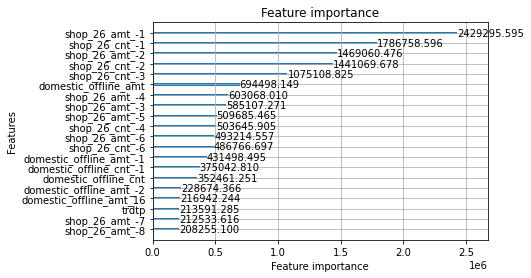

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 13.7918	valid_1's l2: 13.6308
[100]	training's l2: 11.2393	valid_1's l2: 11.0835
[150]	training's l2: 8.81698	valid_1's l2: 8.68137
[200]	training's l2: 6.95238	valid_1's l2: 6.86338
[250]	training's l2: 5.70026	valid_1's l2: 5.67569
[300]	training's l2: 5.00219	valid_1's l2: 5.05138
[350]	training's l2: 4.58338	valid_1's l2: 4.70516
[400]	training's l2: 4.34038	valid_1's l2: 4.53118
[450]	training's l2: 4.18228	valid_1's l2: 4.43671
[500]	training's l2: 4.06382	valid_1's l2: 4.37626
[550]	training's l2: 3.97541	valid_1's l2: 4.34137
[600]	training's l2: 3.89985	valid_1's l2: 4.31525
[650]	training's l2: 3.83628	valid_1's l2: 4.29843
[700]	training's l2: 3.77965	valid_1's l2: 4.2807
[750]	training's l2: 3.73315	valid_1's l2: 4.27222
[800]	training's l2: 3.68603	valid_1's l2: 4.2632
[850]	training's l2: 3.64364	valid_1's l2: 4.25693
[900]	training's l2: 3.59924	valid_1's l2: 4.2495
[950]	training's l2: 3.5

<Figure size 864x432 with 0 Axes>

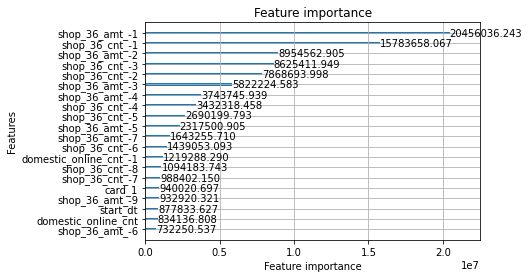

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 4.81269	valid_1's l2: 4.48157
[100]	training's l2: 3.95133	valid_1's l2: 3.65926
[150]	training's l2: 3.27318	valid_1's l2: 3.02951
[200]	training's l2: 2.79388	valid_1's l2: 2.60186
[250]	training's l2: 2.49234	valid_1's l2: 2.34833
[300]	training's l2: 2.30212	valid_1's l2: 2.20029
[350]	training's l2: 2.19073	valid_1's l2: 2.12468
[400]	training's l2: 2.11467	valid_1's l2: 2.08136
[450]	training's l2: 2.05731	valid_1's l2: 2.05276
[500]	training's l2: 2.01406	valid_1's l2: 2.03506
[550]	training's l2: 1.97822	valid_1's l2: 2.0233
[600]	training's l2: 1.94297	valid_1's l2: 2.01306
[650]	training's l2: 1.91394	valid_1's l2: 2.00678
[700]	training's l2: 1.88621	valid_1's l2: 2.0003
[750]	training's l2: 1.864	valid_1's l2: 1.99593
[800]	training's l2: 1.84431	valid_1's l2: 1.99349
[850]	training's l2: 1.82454	valid_1's l2: 1.99063
[900]	training's l2: 1.80524	valid_1's l2: 1.98786
[950]	training's l2: 1.78

<Figure size 864x432 with 0 Axes>

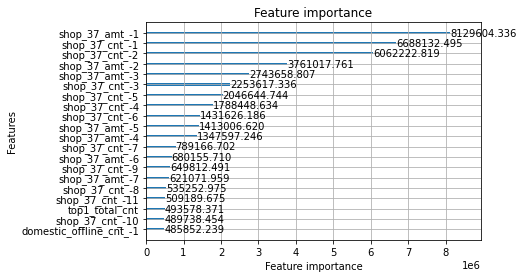

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.118151	valid_1's l2: 0.127471
[100]	training's l2: 0.113645	valid_1's l2: 0.123606
[150]	training's l2: 0.109205	valid_1's l2: 0.119985
[200]	training's l2: 0.104982	valid_1's l2: 0.116727
[250]	training's l2: 0.101373	valid_1's l2: 0.114233
[300]	training's l2: 0.0983279	valid_1's l2: 0.112393
[350]	training's l2: 0.0958103	valid_1's l2: 0.111104
[400]	training's l2: 0.0937942	valid_1's l2: 0.110267
[450]	training's l2: 0.0920117	valid_1's l2: 0.109703
[500]	training's l2: 0.0904776	valid_1's l2: 0.109392
[550]	training's l2: 0.0891097	valid_1's l2: 0.109144
[600]	training's l2: 0.0877964	valid_1's l2: 0.108912
[650]	training's l2: 0.0865598	valid_1's l2: 0.108844
[700]	training's l2: 0.0855711	valid_1's l2: 0.108808
[750]	training's l2: 0.0844595	valid_1's l2: 0.108817
[800]	training's l2: 0.0834156	valid_1's l2: 0.108863
Early stopping, best iteration is:
[721]	training's l2: 0.0850966	valid_1's l2: 

<Figure size 864x432 with 0 Axes>

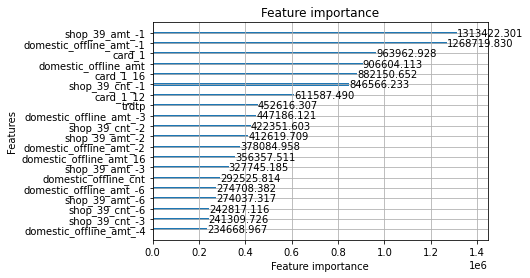

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.11915	valid_1's l2: 2.14004
[100]	training's l2: 1.87935	valid_1's l2: 1.90662
[150]	training's l2: 1.62777	valid_1's l2: 1.66293
[200]	training's l2: 1.40461	valid_1's l2: 1.44938
[250]	training's l2: 1.23678	valid_1's l2: 1.29333
[300]	training's l2: 1.11875	valid_1's l2: 1.18963
[350]	training's l2: 1.04411	valid_1's l2: 1.13053
[400]	training's l2: 0.990706	valid_1's l2: 1.09348
[450]	training's l2: 0.953469	valid_1's l2: 1.07336
[500]	training's l2: 0.923063	valid_1's l2: 1.05957
[550]	training's l2: 0.898787	valid_1's l2: 1.05282
[600]	training's l2: 0.87783	valid_1's l2: 1.04804
[650]	training's l2: 0.858733	valid_1's l2: 1.04338
[700]	training's l2: 0.842621	valid_1's l2: 1.04133
[750]	training's l2: 0.827685	valid_1's l2: 1.03886
[800]	training's l2: 0.813159	valid_1's l2: 1.03603
[850]	training's l2: 0.79925	valid_1's l2: 1.03306
[900]	training's l2: 0.787468	valid_1's l2: 1.03171
[950]	traini

<Figure size 864x432 with 0 Axes>

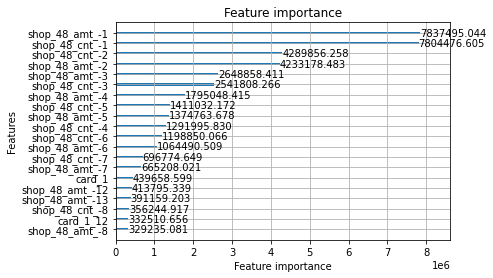

Training fold 2
Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.09532	valid_1's l2: 2.09844
[100]	training's l2: 1.86079	valid_1's l2: 1.87118
[150]	training's l2: 1.6463	valid_1's l2: 1.66452
[200]	training's l2: 1.47698	valid_1's l2: 1.50468
[250]	training's l2: 1.35594	valid_1's l2: 1.39442
[300]	training's l2: 1.28041	valid_1's l2: 1.33194
[350]	training's l2: 1.23016	valid_1's l2: 1.29544
[400]	training's l2: 1.19632	valid_1's l2: 1.27623
[450]	training's l2: 1.17067	valid_1's l2: 1.26574
[500]	training's l2: 1.14995	valid_1's l2: 1.26022
[550]	training's l2: 1.13115	valid_1's l2: 1.25658
[600]	training's l2: 1.11468	valid_1's l2: 1.25453
[650]	training's l2: 1.0992	valid_1's l2: 1.25275
[700]	training's l2: 1.08563	valid_1's l2: 1.25151
[750]	training's l2: 1.07334	valid_1's l2: 1.25028
[800]	training's l2: 1.06253	valid_1's l2: 1.2496
[850]	training's l2: 1.05237	valid_1's l2: 1.2491
[900]	training's l2: 1.04208	valid_1's l2: 1.24873
[950]	tra

<Figure size 864x432 with 0 Axes>

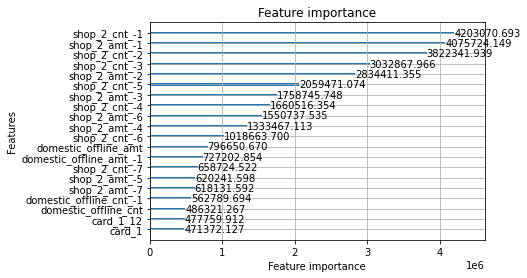

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.131704	valid_1's l2: 0.129957
[100]	training's l2: 0.120234	valid_1's l2: 0.118951
[150]	training's l2: 0.108471	valid_1's l2: 0.107722
[200]	training's l2: 0.0985505	valid_1's l2: 0.0984698
[250]	training's l2: 0.0909298	valid_1's l2: 0.0916774
[300]	training's l2: 0.0856654	valid_1's l2: 0.0873185
[350]	training's l2: 0.0822761	valid_1's l2: 0.0848806
[400]	training's l2: 0.0798607	valid_1's l2: 0.0833809
[450]	training's l2: 0.0780781	valid_1's l2: 0.0826632
[500]	training's l2: 0.0767299	valid_1's l2: 0.0823124
[550]	training's l2: 0.0755098	valid_1's l2: 0.0821274
[600]	training's l2: 0.0743692	valid_1's l2: 0.0820395
[650]	training's l2: 0.0732351	valid_1's l2: 0.0819743
[700]	training's l2: 0.0722617	valid_1's l2: 0.0819997
Early stopping, best iteration is:
[641]	training's l2: 0.0734245	valid_1's l2: 0.0819596


<Figure size 864x432 with 0 Axes>

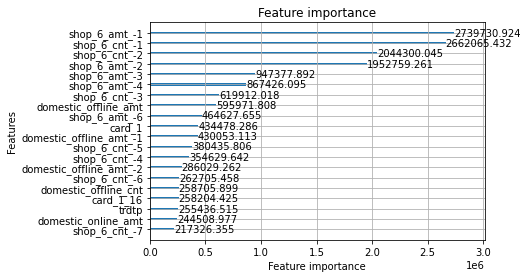

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 10.8828	valid_1's l2: 6.54177
[100]	training's l2: 10.2413	valid_1's l2: 5.93396
[150]	training's l2: 9.52423	valid_1's l2: 5.28088
[200]	training's l2: 8.8131	valid_1's l2: 4.65517
[250]	training's l2: 8.22698	valid_1's l2: 4.17081
[300]	training's l2: 7.77345	valid_1's l2: 3.84337
[350]	training's l2: 7.45661	valid_1's l2: 3.65276
[400]	training's l2: 7.21429	valid_1's l2: 3.54043
[450]	training's l2: 6.99731	valid_1's l2: 3.47336
[500]	training's l2: 6.80904	valid_1's l2: 3.43956
[550]	training's l2: 6.61607	valid_1's l2: 3.41589
[600]	training's l2: 6.44437	valid_1's l2: 3.39704
[650]	training's l2: 6.27106	valid_1's l2: 3.39138
[700]	training's l2: 6.08541	valid_1's l2: 3.38402
[750]	training's l2: 5.88896	valid_1's l2: 3.37609
[800]	training's l2: 5.6937	valid_1's l2: 3.37279
[850]	training's l2: 5.53631	valid_1's l2: 3.36809
[900]	training's l2: 5.41743	valid_1's l2: 3.36669
[950]	training's l2: 5.

<Figure size 864x432 with 0 Axes>

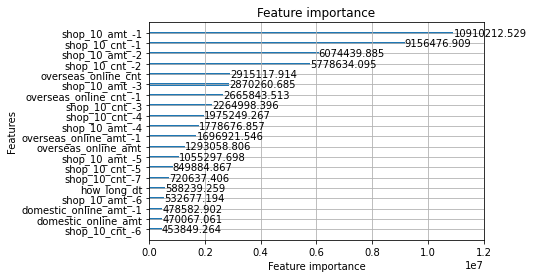

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.239699	valid_1's l2: 0.298121
[100]	training's l2: 0.212188	valid_1's l2: 0.270896
[150]	training's l2: 0.188625	valid_1's l2: 0.24764
[200]	training's l2: 0.170678	valid_1's l2: 0.230084
[250]	training's l2: 0.15845	valid_1's l2: 0.21839
[300]	training's l2: 0.150683	valid_1's l2: 0.211509
[350]	training's l2: 0.14533	valid_1's l2: 0.207257
[400]	training's l2: 0.141375	valid_1's l2: 0.204532
[450]	training's l2: 0.138394	valid_1's l2: 0.202956
[500]	training's l2: 0.13571	valid_1's l2: 0.201659
[550]	training's l2: 0.132929	valid_1's l2: 0.199923
[600]	training's l2: 0.130363	valid_1's l2: 0.198917
[650]	training's l2: 0.127845	valid_1's l2: 0.197789
[700]	training's l2: 0.12567	valid_1's l2: 0.196726
[750]	training's l2: 0.123615	valid_1's l2: 0.195996
[800]	training's l2: 0.121875	valid_1's l2: 0.195558
[850]	training's l2: 0.120288	valid_1's l2: 0.195331
[900]	training's l2: 0.11875	valid_1's l2: 0

<Figure size 864x432 with 0 Axes>

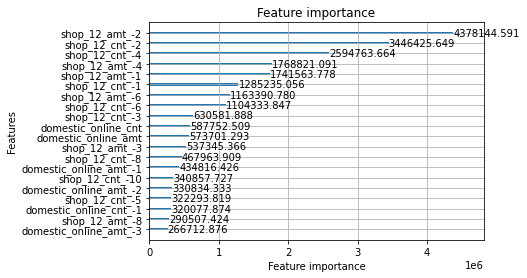

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 3.87259	valid_1's l2: 3.83578
[100]	training's l2: 3.52298	valid_1's l2: 3.49244
[150]	training's l2: 3.10152	valid_1's l2: 3.08185
[200]	training's l2: 2.68862	valid_1's l2: 2.68732
[250]	training's l2: 2.32482	valid_1's l2: 2.34792
[300]	training's l2: 2.05694	valid_1's l2: 2.11071
[350]	training's l2: 1.86267	valid_1's l2: 1.95056
[400]	training's l2: 1.73627	valid_1's l2: 1.86288
[450]	training's l2: 1.63188	valid_1's l2: 1.79933
[500]	training's l2: 1.54179	valid_1's l2: 1.75291
[550]	training's l2: 1.4687	valid_1's l2: 1.72402
[600]	training's l2: 1.4006	valid_1's l2: 1.69701
[650]	training's l2: 1.34783	valid_1's l2: 1.68484
[700]	training's l2: 1.29845	valid_1's l2: 1.67149
[750]	training's l2: 1.25145	valid_1's l2: 1.66196
[800]	training's l2: 1.20872	valid_1's l2: 1.65477
[850]	training's l2: 1.16773	valid_1's l2: 1.64832
[900]	training's l2: 1.13229	valid_1's l2: 1.64379
[950]	training's l2: 1.

<Figure size 864x432 with 0 Axes>

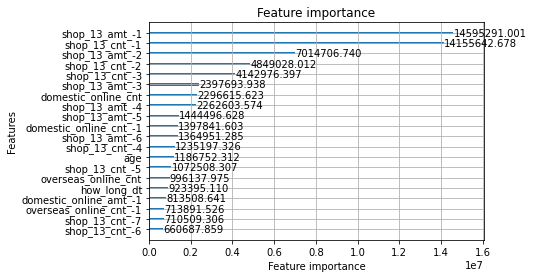

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 5.30209	valid_1's l2: 5.46928
[100]	training's l2: 4.49336	valid_1's l2: 4.65921
[150]	training's l2: 3.77298	valid_1's l2: 3.94031
[200]	training's l2: 3.23349	valid_1's l2: 3.40807
[250]	training's l2: 2.84498	valid_1's l2: 3.03171
[300]	training's l2: 2.58376	valid_1's l2: 2.78838
[350]	training's l2: 2.41915	valid_1's l2: 2.64531
[400]	training's l2: 2.30673	valid_1's l2: 2.55913
[450]	training's l2: 2.22378	valid_1's l2: 2.50361
[500]	training's l2: 2.16246	valid_1's l2: 2.47353
[550]	training's l2: 2.10481	valid_1's l2: 2.44551
[600]	training's l2: 2.05665	valid_1's l2: 2.42786
[650]	training's l2: 2.01356	valid_1's l2: 2.41294
[700]	training's l2: 1.97829	valid_1's l2: 2.40345
[750]	training's l2: 1.94114	valid_1's l2: 2.39101
[800]	training's l2: 1.9077	valid_1's l2: 2.3822
[850]	training's l2: 1.88087	valid_1's l2: 2.37662
[900]	training's l2: 1.85682	valid_1's l2: 2.37298
[950]	training's l2: 1.

<Figure size 864x432 with 0 Axes>

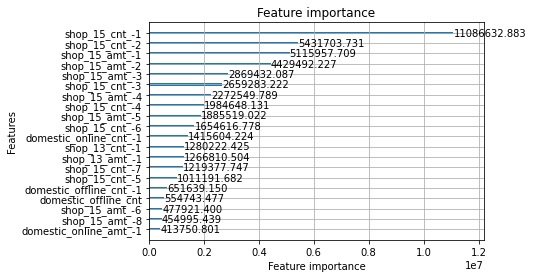

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.170211	valid_1's l2: 0.15385
[100]	training's l2: 0.161516	valid_1's l2: 0.146376
[150]	training's l2: 0.152553	valid_1's l2: 0.139131
[200]	training's l2: 0.144413	valid_1's l2: 0.133169
[250]	training's l2: 0.137461	valid_1's l2: 0.128659
[300]	training's l2: 0.131687	valid_1's l2: 0.12558
[350]	training's l2: 0.126797	valid_1's l2: 0.123433
[400]	training's l2: 0.122985	valid_1's l2: 0.122288
[450]	training's l2: 0.119845	valid_1's l2: 0.121601
[500]	training's l2: 0.116956	valid_1's l2: 0.121277
[550]	training's l2: 0.114419	valid_1's l2: 0.121092
[600]	training's l2: 0.112023	valid_1's l2: 0.12088
[650]	training's l2: 0.109659	valid_1's l2: 0.12074
[700]	training's l2: 0.107534	valid_1's l2: 0.120726
[750]	training's l2: 0.105847	valid_1's l2: 0.120714
[800]	training's l2: 0.104305	valid_1's l2: 0.120735
[850]	training's l2: 0.1027	valid_1's l2: 0.120767
Early stopping, best iteration is:
[760]	tra

<Figure size 864x432 with 0 Axes>

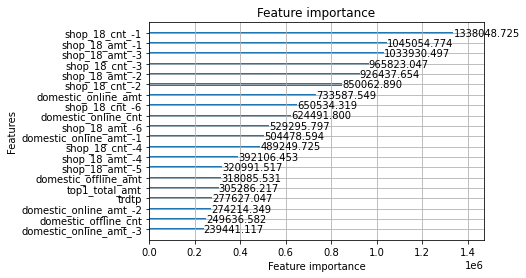

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.256952	valid_1's l2: 0.251133
[100]	training's l2: 0.244064	valid_1's l2: 0.239973
[150]	training's l2: 0.233035	valid_1's l2: 0.23112
[200]	training's l2: 0.223978	valid_1's l2: 0.224551
[250]	training's l2: 0.216944	valid_1's l2: 0.220254
[300]	training's l2: 0.211615	valid_1's l2: 0.217737
[350]	training's l2: 0.207158	valid_1's l2: 0.216146
[400]	training's l2: 0.203369	valid_1's l2: 0.215256
[450]	training's l2: 0.199967	valid_1's l2: 0.214734
[500]	training's l2: 0.196868	valid_1's l2: 0.214391
[550]	training's l2: 0.193838	valid_1's l2: 0.214179
[600]	training's l2: 0.191449	valid_1's l2: 0.21407
[650]	training's l2: 0.188882	valid_1's l2: 0.214097
[700]	training's l2: 0.186534	valid_1's l2: 0.214111
Early stopping, best iteration is:
[601]	training's l2: 0.191406	valid_1's l2: 0.214064


<Figure size 864x432 with 0 Axes>

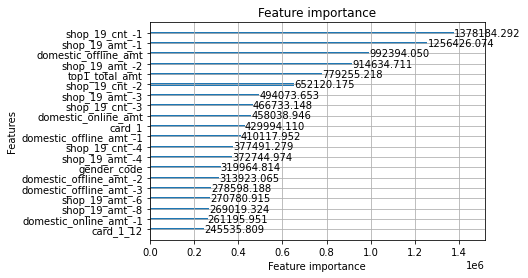

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.213759	valid_1's l2: 0.21577
[100]	training's l2: 0.205856	valid_1's l2: 0.209393
[150]	training's l2: 0.198304	valid_1's l2: 0.203775
[200]	training's l2: 0.191454	valid_1's l2: 0.199201
[250]	training's l2: 0.185455	valid_1's l2: 0.195729
[300]	training's l2: 0.180372	valid_1's l2: 0.193229
[350]	training's l2: 0.176065	valid_1's l2: 0.191494
[400]	training's l2: 0.172177	valid_1's l2: 0.190151
[450]	training's l2: 0.168864	valid_1's l2: 0.189333
[500]	training's l2: 0.165823	valid_1's l2: 0.188587
[550]	training's l2: 0.163084	valid_1's l2: 0.188048
[600]	training's l2: 0.160373	valid_1's l2: 0.187646
[650]	training's l2: 0.158037	valid_1's l2: 0.187387
[700]	training's l2: 0.155564	valid_1's l2: 0.187126
[750]	training's l2: 0.153241	valid_1's l2: 0.187103
[800]	training's l2: 0.151121	valid_1's l2: 0.186922
[850]	training's l2: 0.149294	valid_1's l2: 0.186885
[900]	training's l2: 0.147403	valid_1's

<Figure size 864x432 with 0 Axes>

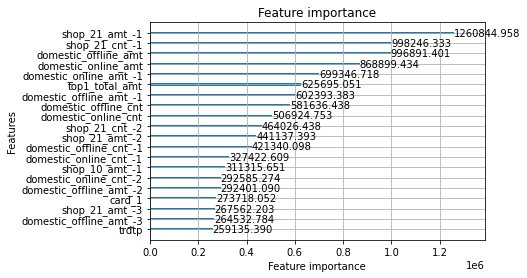

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.179657	valid_1's l2: 0.160283
[100]	training's l2: 0.170248	valid_1's l2: 0.151812
[150]	training's l2: 0.159836	valid_1's l2: 0.142796
[200]	training's l2: 0.149235	valid_1's l2: 0.133992
[250]	training's l2: 0.139909	valid_1's l2: 0.126659
[300]	training's l2: 0.132354	valid_1's l2: 0.121226
[350]	training's l2: 0.126579	valid_1's l2: 0.117531
[400]	training's l2: 0.12234	valid_1's l2: 0.115363
[450]	training's l2: 0.118989	valid_1's l2: 0.114141
[500]	training's l2: 0.115923	valid_1's l2: 0.113411
[550]	training's l2: 0.113054	valid_1's l2: 0.113103
[600]	training's l2: 0.110398	valid_1's l2: 0.112998
[650]	training's l2: 0.107722	valid_1's l2: 0.112905
[700]	training's l2: 0.105268	valid_1's l2: 0.112964
[750]	training's l2: 0.102585	valid_1's l2: 0.11296
Early stopping, best iteration is:
[665]	training's l2: 0.107012	valid_1's l2: 0.112885


<Figure size 864x432 with 0 Axes>

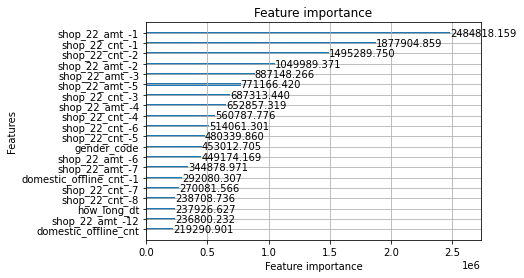

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.243631	valid_1's l2: 0.202888
[100]	training's l2: 0.230423	valid_1's l2: 0.191123
[150]	training's l2: 0.217169	valid_1's l2: 0.17998
[200]	training's l2: 0.205097	valid_1's l2: 0.170648
[250]	training's l2: 0.195102	valid_1's l2: 0.163833
[300]	training's l2: 0.187196	valid_1's l2: 0.159465
[350]	training's l2: 0.181014	valid_1's l2: 0.15686
[400]	training's l2: 0.175333	valid_1's l2: 0.155231
[450]	training's l2: 0.170667	valid_1's l2: 0.154516
[500]	training's l2: 0.166357	valid_1's l2: 0.154205
[550]	training's l2: 0.161948	valid_1's l2: 0.154023
[600]	training's l2: 0.157868	valid_1's l2: 0.154068
[650]	training's l2: 0.153824	valid_1's l2: 0.1541
Early stopping, best iteration is:
[553]	training's l2: 0.161751	valid_1's l2: 0.154014


<Figure size 864x432 with 0 Axes>

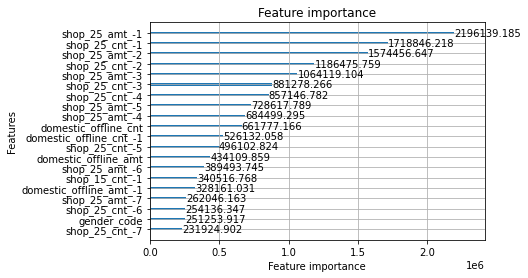

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.128539	valid_1's l2: 0.124695
[100]	training's l2: 0.121815	valid_1's l2: 0.118624
[150]	training's l2: 0.114129	valid_1's l2: 0.111852
[200]	training's l2: 0.106888	valid_1's l2: 0.105792
[250]	training's l2: 0.100722	valid_1's l2: 0.101023
[300]	training's l2: 0.095997	valid_1's l2: 0.0978614
[350]	training's l2: 0.092466	valid_1's l2: 0.0958819
[400]	training's l2: 0.0896333	valid_1's l2: 0.0946305
[450]	training's l2: 0.087351	valid_1's l2: 0.0940193
[500]	training's l2: 0.0854207	valid_1's l2: 0.0937077
[550]	training's l2: 0.083764	valid_1's l2: 0.0935431
[600]	training's l2: 0.0819736	valid_1's l2: 0.0934706
[650]	training's l2: 0.0803974	valid_1's l2: 0.09349
[700]	training's l2: 0.0789008	valid_1's l2: 0.0935007
[750]	training's l2: 0.0774897	valid_1's l2: 0.093576
Early stopping, best iteration is:
[680]	training's l2: 0.0795384	valid_1's l2: 0.0934677


<Figure size 864x432 with 0 Axes>

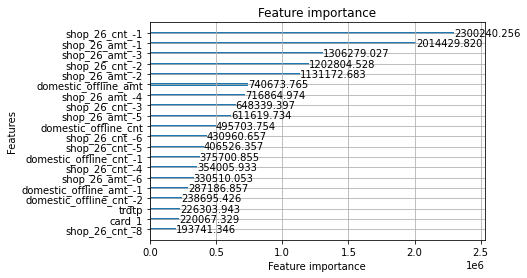

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 13.6994	valid_1's l2: 13.5951
[100]	training's l2: 11.1412	valid_1's l2: 11.1098
[150]	training's l2: 8.75484	valid_1's l2: 8.8187
[200]	training's l2: 6.92013	valid_1's l2: 7.08162
[250]	training's l2: 5.6561	valid_1's l2: 5.90118
[300]	training's l2: 4.93574	valid_1's l2: 5.25131
[350]	training's l2: 4.51607	valid_1's l2: 4.89008
[400]	training's l2: 4.28097	valid_1's l2: 4.71091
[450]	training's l2: 4.12238	valid_1's l2: 4.60247
[500]	training's l2: 4.00621	valid_1's l2: 4.53656
[550]	training's l2: 3.91888	valid_1's l2: 4.49835
[600]	training's l2: 3.83957	valid_1's l2: 4.46425
[650]	training's l2: 3.77805	valid_1's l2: 4.44251
[700]	training's l2: 3.71913	valid_1's l2: 4.42319
[750]	training's l2: 3.67135	valid_1's l2: 4.40815
[800]	training's l2: 3.62615	valid_1's l2: 4.39676
[850]	training's l2: 3.58346	valid_1's l2: 4.38824
[900]	training's l2: 3.54113	valid_1's l2: 4.37987
[950]	training's l2: 3.

<Figure size 864x432 with 0 Axes>

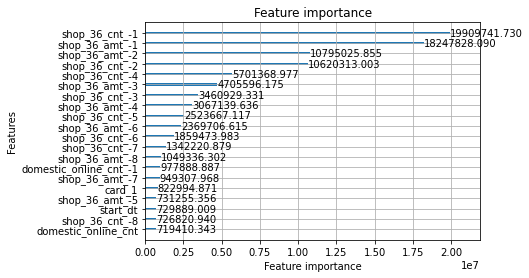

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 4.58398	valid_1's l2: 4.93339
[100]	training's l2: 3.74118	valid_1's l2: 4.09809
[150]	training's l2: 3.08181	valid_1's l2: 3.44413
[200]	training's l2: 2.62634	valid_1's l2: 2.99355
[250]	training's l2: 2.3243	valid_1's l2: 2.69487
[300]	training's l2: 2.15579	valid_1's l2: 2.53314
[350]	training's l2: 2.05038	valid_1's l2: 2.43753
[400]	training's l2: 1.98372	valid_1's l2: 2.38497
[450]	training's l2: 1.93289	valid_1's l2: 2.34892
[500]	training's l2: 1.89501	valid_1's l2: 2.32509
[550]	training's l2: 1.86248	valid_1's l2: 2.30595
[600]	training's l2: 1.83539	valid_1's l2: 2.29085
[650]	training's l2: 1.80988	valid_1's l2: 2.27801
[700]	training's l2: 1.7898	valid_1's l2: 2.2706
[750]	training's l2: 1.7711	valid_1's l2: 2.26551
[800]	training's l2: 1.75428	valid_1's l2: 2.26061
[850]	training's l2: 1.73644	valid_1's l2: 2.24802
[900]	training's l2: 1.72171	valid_1's l2: 2.24382
[950]	training's l2: 1.70

<Figure size 864x432 with 0 Axes>

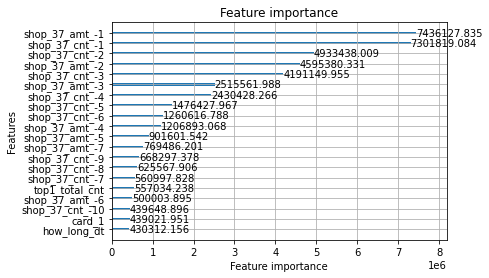

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.122635	valid_1's l2: 0.118393
[100]	training's l2: 0.118021	valid_1's l2: 0.114539
[150]	training's l2: 0.11335	valid_1's l2: 0.110893
[200]	training's l2: 0.109015	valid_1's l2: 0.107811
[250]	training's l2: 0.105331	valid_1's l2: 0.105482
[300]	training's l2: 0.102247	valid_1's l2: 0.103845
[350]	training's l2: 0.0996881	valid_1's l2: 0.102776
[400]	training's l2: 0.0975094	valid_1's l2: 0.102154
[450]	training's l2: 0.095618	valid_1's l2: 0.101746
[500]	training's l2: 0.0939148	valid_1's l2: 0.101453
[550]	training's l2: 0.0923822	valid_1's l2: 0.101262
[600]	training's l2: 0.0908538	valid_1's l2: 0.10115
[650]	training's l2: 0.0894599	valid_1's l2: 0.101086
[700]	training's l2: 0.0882768	valid_1's l2: 0.101057
[750]	training's l2: 0.0872078	valid_1's l2: 0.101049
Early stopping, best iteration is:
[683]	training's l2: 0.0886244	valid_1's l2: 0.101034


<Figure size 864x432 with 0 Axes>

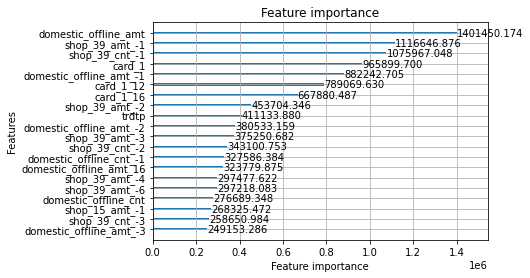

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.06391	valid_1's l2: 2.24594
[100]	training's l2: 1.83127	valid_1's l2: 2.009
[150]	training's l2: 1.59365	valid_1's l2: 1.76538
[200]	training's l2: 1.38163	valid_1's l2: 1.54762
[250]	training's l2: 1.21706	valid_1's l2: 1.37921
[300]	training's l2: 1.10867	valid_1's l2: 1.27196
[350]	training's l2: 1.03507	valid_1's l2: 1.20265
[400]	training's l2: 0.986836	valid_1's l2: 1.16187
[450]	training's l2: 0.950634	valid_1's l2: 1.13504
[500]	training's l2: 0.920596	valid_1's l2: 1.11485
[550]	training's l2: 0.896192	valid_1's l2: 1.1012
[600]	training's l2: 0.875966	valid_1's l2: 1.09391
[650]	training's l2: 0.858578	valid_1's l2: 1.08705
[700]	training's l2: 0.843699	valid_1's l2: 1.08326
[750]	training's l2: 0.830265	valid_1's l2: 1.08034
[800]	training's l2: 0.816475	valid_1's l2: 1.07829
[850]	training's l2: 0.804307	valid_1's l2: 1.07615
[900]	training's l2: 0.792279	valid_1's l2: 1.07433
[950]	trainin

<Figure size 864x432 with 0 Axes>

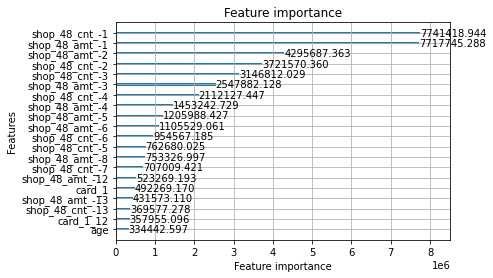

Training fold 3
Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.11242	valid_1's l2: 2.06512
[100]	training's l2: 1.87443	valid_1's l2: 1.84225
[150]	training's l2: 1.65288	valid_1's l2: 1.6405
[200]	training's l2: 1.48039	valid_1's l2: 1.49001
[250]	training's l2: 1.35819	valid_1's l2: 1.38924
[300]	training's l2: 1.27966	valid_1's l2: 1.32999
[350]	training's l2: 1.22863	valid_1's l2: 1.29651
[400]	training's l2: 1.19385	valid_1's l2: 1.27827
[450]	training's l2: 1.16798	valid_1's l2: 1.26768
[500]	training's l2: 1.14674	valid_1's l2: 1.26151
[550]	training's l2: 1.12814	valid_1's l2: 1.25689
[600]	training's l2: 1.1126	valid_1's l2: 1.25535
[650]	training's l2: 1.0982	valid_1's l2: 1.25349
[700]	training's l2: 1.08469	valid_1's l2: 1.25183
[750]	training's l2: 1.07185	valid_1's l2: 1.2502
[800]	training's l2: 1.06059	valid_1's l2: 1.24934
[850]	training's l2: 1.05066	valid_1's l2: 1.24885
[900]	training's l2: 1.04131	valid_1's l2: 1.24826
[950]	tra

<Figure size 864x432 with 0 Axes>

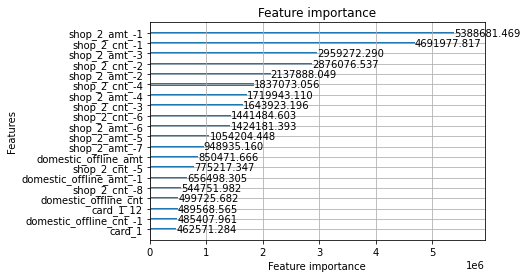

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.132713	valid_1's l2: 0.128168
[100]	training's l2: 0.121301	valid_1's l2: 0.117735
[150]	training's l2: 0.109051	valid_1's l2: 0.106692
[200]	training's l2: 0.0983092	valid_1's l2: 0.0973435
[250]	training's l2: 0.0904509	valid_1's l2: 0.090865
[300]	training's l2: 0.0853774	valid_1's l2: 0.0870769
[350]	training's l2: 0.0820377	valid_1's l2: 0.084965
[400]	training's l2: 0.0797067	valid_1's l2: 0.0837662
[450]	training's l2: 0.0779379	valid_1's l2: 0.0830315
[500]	training's l2: 0.0766353	valid_1's l2: 0.0827152
[550]	training's l2: 0.0753785	valid_1's l2: 0.0824928
[600]	training's l2: 0.0740958	valid_1's l2: 0.0823044
[650]	training's l2: 0.073047	valid_1's l2: 0.0822155
[700]	training's l2: 0.0718966	valid_1's l2: 0.0821255
[750]	training's l2: 0.0709435	valid_1's l2: 0.0820683
[800]	training's l2: 0.0699597	valid_1's l2: 0.0820788
[850]	training's l2: 0.0691007	valid_1's l2: 0.082079
Early stopping

<Figure size 864x432 with 0 Axes>

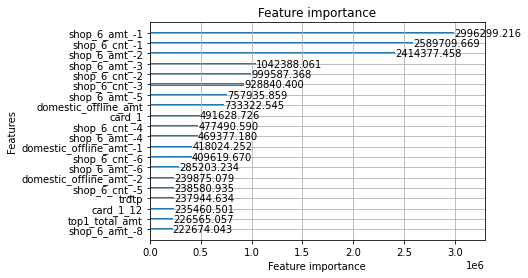

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 7.03147	valid_1's l2: 14.254
[100]	training's l2: 6.41928	valid_1's l2: 13.6508
[150]	training's l2: 5.7328	valid_1's l2: 12.9712
[200]	training's l2: 5.09443	valid_1's l2: 12.3444
[250]	training's l2: 4.56151	valid_1's l2: 11.8279
[300]	training's l2: 4.1727	valid_1's l2: 11.461
[350]	training's l2: 3.90474	valid_1's l2: 11.2225
[400]	training's l2: 3.72319	valid_1's l2: 11.079
[450]	training's l2: 3.5854	valid_1's l2: 10.9856
[500]	training's l2: 3.47247	valid_1's l2: 10.929
[550]	training's l2: 3.37022	valid_1's l2: 10.8774
[600]	training's l2: 3.28328	valid_1's l2: 10.8456
[650]	training's l2: 3.19019	valid_1's l2: 10.8137
[700]	training's l2: 3.11822	valid_1's l2: 10.7991
[750]	training's l2: 3.04573	valid_1's l2: 10.7753
[800]	training's l2: 2.98492	valid_1's l2: 10.7657
[850]	training's l2: 2.92299	valid_1's l2: 10.7562
[900]	training's l2: 2.85755	valid_1's l2: 10.7457
[950]	training's l2: 2.80814

<Figure size 864x432 with 0 Axes>

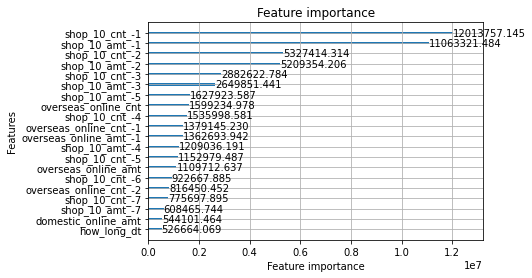

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.267685	valid_1's l2: 0.243519
[100]	training's l2: 0.239971	valid_1's l2: 0.216993
[150]	training's l2: 0.215808	valid_1's l2: 0.194289
[200]	training's l2: 0.197093	valid_1's l2: 0.177357
[250]	training's l2: 0.183989	valid_1's l2: 0.16622
[300]	training's l2: 0.175196	valid_1's l2: 0.159611
[350]	training's l2: 0.168999	valid_1's l2: 0.155682
[400]	training's l2: 0.164617	valid_1's l2: 0.153556
[450]	training's l2: 0.160804	valid_1's l2: 0.152231
[500]	training's l2: 0.156672	valid_1's l2: 0.150989
[550]	training's l2: 0.152257	valid_1's l2: 0.149854
[600]	training's l2: 0.148198	valid_1's l2: 0.149191
[650]	training's l2: 0.144056	valid_1's l2: 0.148924
[700]	training's l2: 0.140395	valid_1's l2: 0.14892
[750]	training's l2: 0.137792	valid_1's l2: 0.149123
Early stopping, best iteration is:
[664]	training's l2: 0.142884	valid_1's l2: 0.14888


<Figure size 864x432 with 0 Axes>

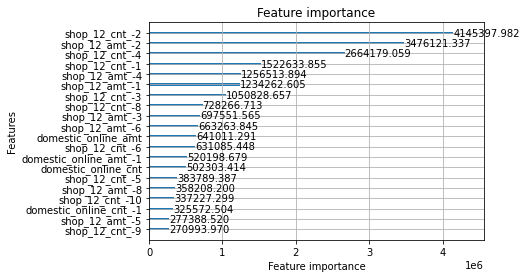

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 3.88614	valid_1's l2: 3.81319
[100]	training's l2: 3.52955	valid_1's l2: 3.47614
[150]	training's l2: 3.09148	valid_1's l2: 3.07102
[200]	training's l2: 2.66378	valid_1's l2: 2.68794
[250]	training's l2: 2.3084	valid_1's l2: 2.38117
[300]	training's l2: 2.04696	valid_1's l2: 2.16849
[350]	training's l2: 1.86005	valid_1's l2: 2.02486
[400]	training's l2: 1.72257	valid_1's l2: 1.93231
[450]	training's l2: 1.62118	valid_1's l2: 1.87078
[500]	training's l2: 1.53802	valid_1's l2: 1.82881
[550]	training's l2: 1.46622	valid_1's l2: 1.79618
[600]	training's l2: 1.40656	valid_1's l2: 1.77335
[650]	training's l2: 1.34388	valid_1's l2: 1.74949
[700]	training's l2: 1.29373	valid_1's l2: 1.73302
[750]	training's l2: 1.24561	valid_1's l2: 1.71923
[800]	training's l2: 1.20249	valid_1's l2: 1.70733
[850]	training's l2: 1.16323	valid_1's l2: 1.70024
[900]	training's l2: 1.12504	valid_1's l2: 1.69365
[950]	training's l2: 1

<Figure size 864x432 with 0 Axes>

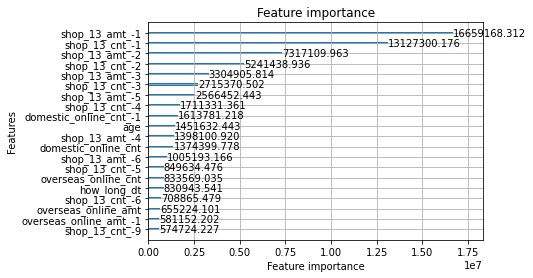

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 5.40906	valid_1's l2: 5.22605
[100]	training's l2: 4.59088	valid_1's l2: 4.43632
[150]	training's l2: 3.86318	valid_1's l2: 3.74864
[200]	training's l2: 3.29725	valid_1's l2: 3.22662
[250]	training's l2: 2.89878	valid_1's l2: 2.87106
[300]	training's l2: 2.65611	valid_1's l2: 2.66836
[350]	training's l2: 2.49206	valid_1's l2: 2.54183
[400]	training's l2: 2.37765	valid_1's l2: 2.46392
[450]	training's l2: 2.29542	valid_1's l2: 2.41673
[500]	training's l2: 2.22473	valid_1's l2: 2.38052
[550]	training's l2: 2.16617	valid_1's l2: 2.35555
[600]	training's l2: 2.11524	valid_1's l2: 2.33544
[650]	training's l2: 2.06829	valid_1's l2: 2.31962
[700]	training's l2: 2.02989	valid_1's l2: 2.3102
[750]	training's l2: 1.99182	valid_1's l2: 2.30012
[800]	training's l2: 1.96057	valid_1's l2: 2.29333
[850]	training's l2: 1.93206	valid_1's l2: 2.28953
[900]	training's l2: 1.9047	valid_1's l2: 2.28584
[950]	training's l2: 1.

<Figure size 864x432 with 0 Axes>

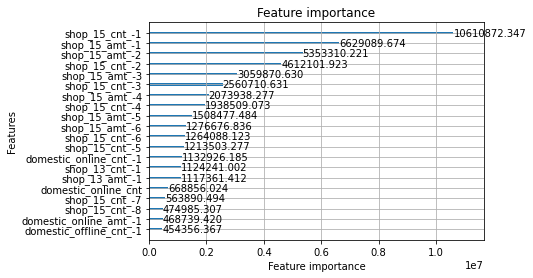

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.166185	valid_1's l2: 0.161614
[100]	training's l2: 0.15745	valid_1's l2: 0.153828
[150]	training's l2: 0.148833	valid_1's l2: 0.1464
[200]	training's l2: 0.14094	valid_1's l2: 0.139848
[250]	training's l2: 0.134339	valid_1's l2: 0.13475
[300]	training's l2: 0.129192	valid_1's l2: 0.131178
[350]	training's l2: 0.12493	valid_1's l2: 0.128598
[400]	training's l2: 0.121489	valid_1's l2: 0.126796
[450]	training's l2: 0.118615	valid_1's l2: 0.12562
[500]	training's l2: 0.116053	valid_1's l2: 0.12479
[550]	training's l2: 0.113583	valid_1's l2: 0.124164
[600]	training's l2: 0.111445	valid_1's l2: 0.12379
[650]	training's l2: 0.109445	valid_1's l2: 0.123429
[700]	training's l2: 0.10759	valid_1's l2: 0.123245
[750]	training's l2: 0.106036	valid_1's l2: 0.123132
[800]	training's l2: 0.104498	valid_1's l2: 0.123005
[850]	training's l2: 0.103146	valid_1's l2: 0.122922
[900]	training's l2: 0.101933	valid_1's l2: 0.12

<Figure size 864x432 with 0 Axes>

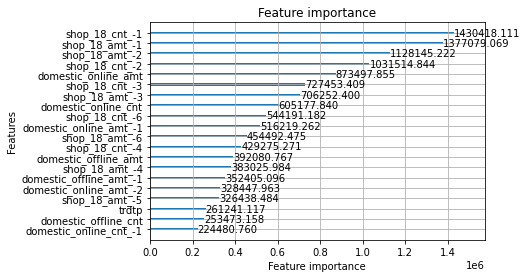

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.244362	valid_1's l2: 0.276809
[100]	training's l2: 0.231717	valid_1's l2: 0.265472
[150]	training's l2: 0.221023	valid_1's l2: 0.25631
[200]	training's l2: 0.212387	valid_1's l2: 0.249405
[250]	training's l2: 0.205743	valid_1's l2: 0.244748
[300]	training's l2: 0.200693	valid_1's l2: 0.241786
[350]	training's l2: 0.196587	valid_1's l2: 0.239847
[400]	training's l2: 0.192992	valid_1's l2: 0.238556
[450]	training's l2: 0.189943	valid_1's l2: 0.237822
[500]	training's l2: 0.187177	valid_1's l2: 0.237248
[550]	training's l2: 0.184611	valid_1's l2: 0.23682
[600]	training's l2: 0.182211	valid_1's l2: 0.236552
[650]	training's l2: 0.179928	valid_1's l2: 0.236351
[700]	training's l2: 0.177862	valid_1's l2: 0.236248
[750]	training's l2: 0.175791	valid_1's l2: 0.236168
[800]	training's l2: 0.173892	valid_1's l2: 0.236139
[850]	training's l2: 0.172038	valid_1's l2: 0.236109
[900]	training's l2: 0.170331	valid_1's 

<Figure size 864x432 with 0 Axes>

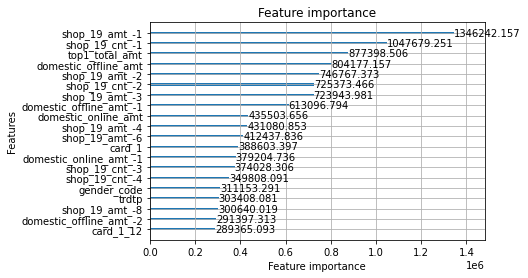

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.217543	valid_1's l2: 0.208252
[100]	training's l2: 0.209658	valid_1's l2: 0.201613
[150]	training's l2: 0.202186	valid_1's l2: 0.195673
[200]	training's l2: 0.195477	valid_1's l2: 0.190774
[250]	training's l2: 0.189697	valid_1's l2: 0.187017
[300]	training's l2: 0.184689	valid_1's l2: 0.184244
[350]	training's l2: 0.180409	valid_1's l2: 0.182235
[400]	training's l2: 0.176635	valid_1's l2: 0.181072
[450]	training's l2: 0.173209	valid_1's l2: 0.180294
[500]	training's l2: 0.170171	valid_1's l2: 0.179747
[550]	training's l2: 0.167279	valid_1's l2: 0.17942
[600]	training's l2: 0.164398	valid_1's l2: 0.179132
[650]	training's l2: 0.161539	valid_1's l2: 0.178772
[700]	training's l2: 0.159042	valid_1's l2: 0.17868
[750]	training's l2: 0.156931	valid_1's l2: 0.178601
[800]	training's l2: 0.154197	valid_1's l2: 0.178484
[850]	training's l2: 0.152081	valid_1's l2: 0.17848
[900]	training's l2: 0.149773	valid_1's l

<Figure size 864x432 with 0 Axes>

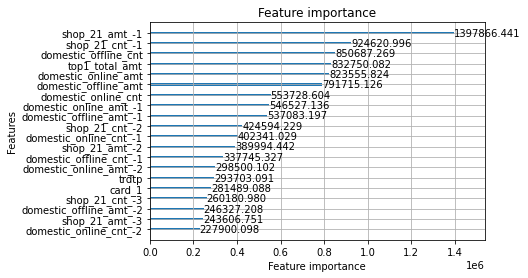

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.16958	valid_1's l2: 0.180969
[100]	training's l2: 0.1605	valid_1's l2: 0.172195
[150]	training's l2: 0.15026	valid_1's l2: 0.162253
[200]	training's l2: 0.140198	valid_1's l2: 0.152565
[250]	training's l2: 0.131445	valid_1's l2: 0.144377
[300]	training's l2: 0.124315	valid_1's l2: 0.138014
[350]	training's l2: 0.119015	valid_1's l2: 0.133738
[400]	training's l2: 0.115206	valid_1's l2: 0.131249
[450]	training's l2: 0.112093	valid_1's l2: 0.129536
[500]	training's l2: 0.109736	valid_1's l2: 0.128761
[550]	training's l2: 0.107441	valid_1's l2: 0.128135
[600]	training's l2: 0.105409	valid_1's l2: 0.127833
[650]	training's l2: 0.103685	valid_1's l2: 0.127663
[700]	training's l2: 0.101891	valid_1's l2: 0.127558
[750]	training's l2: 0.100277	valid_1's l2: 0.127403
[800]	training's l2: 0.0986651	valid_1's l2: 0.127337
[850]	training's l2: 0.0970727	valid_1's l2: 0.127281
[900]	training's l2: 0.0956994	valid_1's

<Figure size 864x432 with 0 Axes>

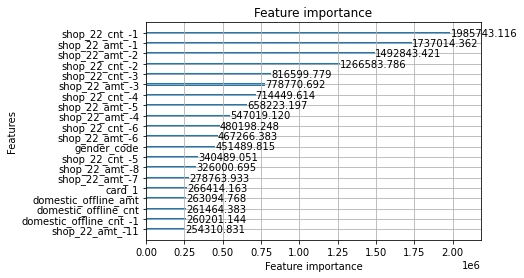

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.220752	valid_1's l2: 0.2495
[100]	training's l2: 0.208054	valid_1's l2: 0.237235
[150]	training's l2: 0.195523	valid_1's l2: 0.225182
[200]	training's l2: 0.184325	valid_1's l2: 0.214567
[250]	training's l2: 0.175203	valid_1's l2: 0.206285
[300]	training's l2: 0.168304	valid_1's l2: 0.200514
[350]	training's l2: 0.163031	valid_1's l2: 0.196652
[400]	training's l2: 0.158833	valid_1's l2: 0.194042
[450]	training's l2: 0.155254	valid_1's l2: 0.192247
[500]	training's l2: 0.152124	valid_1's l2: 0.191133
[550]	training's l2: 0.149147	valid_1's l2: 0.19041
[600]	training's l2: 0.146428	valid_1's l2: 0.189828
[650]	training's l2: 0.14375	valid_1's l2: 0.189302
[700]	training's l2: 0.140942	valid_1's l2: 0.188709
[750]	training's l2: 0.138583	valid_1's l2: 0.18819
[800]	training's l2: 0.13626	valid_1's l2: 0.187877
[850]	training's l2: 0.134061	valid_1's l2: 0.187571
[900]	training's l2: 0.132206	valid_1's l2: 

<Figure size 864x432 with 0 Axes>

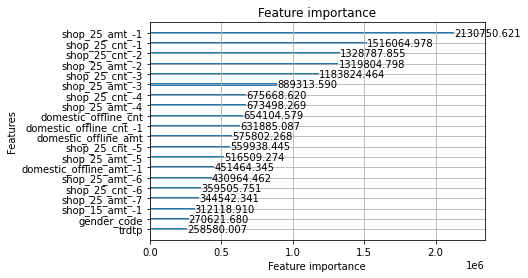

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.127237	valid_1's l2: 0.127472
[100]	training's l2: 0.120762	valid_1's l2: 0.121603
[150]	training's l2: 0.11335	valid_1's l2: 0.115077
[200]	training's l2: 0.10623	valid_1's l2: 0.109105
[250]	training's l2: 0.0999521	valid_1's l2: 0.104151
[300]	training's l2: 0.0951585	valid_1's l2: 0.100793
[350]	training's l2: 0.0917656	valid_1's l2: 0.0988214
[400]	training's l2: 0.0889953	valid_1's l2: 0.0975631
[450]	training's l2: 0.0866613	valid_1's l2: 0.0967258
[500]	training's l2: 0.0847216	valid_1's l2: 0.0963599
[550]	training's l2: 0.0828273	valid_1's l2: 0.0961244
[600]	training's l2: 0.0811411	valid_1's l2: 0.0960153
[650]	training's l2: 0.0797071	valid_1's l2: 0.0959168
[700]	training's l2: 0.0782844	valid_1's l2: 0.0959147
[750]	training's l2: 0.0770877	valid_1's l2: 0.09592
Early stopping, best iteration is:
[673]	training's l2: 0.0790547	valid_1's l2: 0.0959


<Figure size 864x432 with 0 Axes>

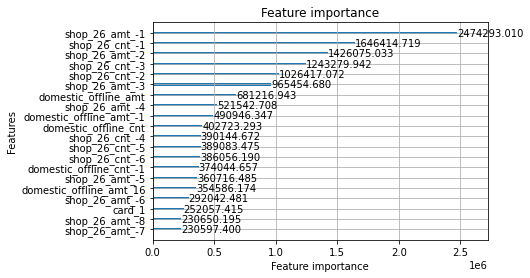

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 13.5987	valid_1's l2: 13.926
[100]	training's l2: 11.0199	valid_1's l2: 11.361
[150]	training's l2: 8.67058	valid_1's l2: 9.02466
[200]	training's l2: 6.81627	valid_1's l2: 7.18014
[250]	training's l2: 5.59968	valid_1's l2: 5.97589
[300]	training's l2: 4.88006	valid_1's l2: 5.27695
[350]	training's l2: 4.48651	valid_1's l2: 4.91252
[400]	training's l2: 4.24839	valid_1's l2: 4.70963
[450]	training's l2: 4.09558	valid_1's l2: 4.59462
[500]	training's l2: 3.98686	valid_1's l2: 4.52715
[550]	training's l2: 3.90386	valid_1's l2: 4.48334
[600]	training's l2: 3.83505	valid_1's l2: 4.45655
[650]	training's l2: 3.77288	valid_1's l2: 4.43105
[700]	training's l2: 3.71949	valid_1's l2: 4.41292
[750]	training's l2: 3.67176	valid_1's l2: 4.39951
[800]	training's l2: 3.62936	valid_1's l2: 4.39056
[850]	training's l2: 3.58601	valid_1's l2: 4.38312
[900]	training's l2: 3.54396	valid_1's l2: 4.37558
[950]	training's l2: 3.

<Figure size 864x432 with 0 Axes>

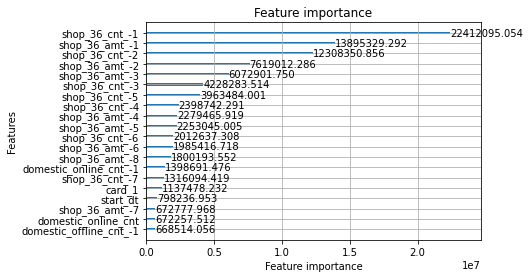

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 4.68631	valid_1's l2: 4.70733
[100]	training's l2: 3.84347	valid_1's l2: 3.86696
[150]	training's l2: 3.19297	valid_1's l2: 3.2215
[200]	training's l2: 2.72863	valid_1's l2: 2.76471
[250]	training's l2: 2.44156	valid_1's l2: 2.49107
[300]	training's l2: 2.2624	valid_1's l2: 2.3293
[350]	training's l2: 2.15436	valid_1's l2: 2.24204
[400]	training's l2: 2.08005	valid_1's l2: 2.19003
[450]	training's l2: 2.02146	valid_1's l2: 2.15385
[500]	training's l2: 1.98018	valid_1's l2: 2.13341
[550]	training's l2: 1.94212	valid_1's l2: 2.11585
[600]	training's l2: 1.90993	valid_1's l2: 2.10371
[650]	training's l2: 1.88317	valid_1's l2: 2.09507
[700]	training's l2: 1.85827	valid_1's l2: 2.08756
[750]	training's l2: 1.83762	valid_1's l2: 2.0827
[800]	training's l2: 1.81489	valid_1's l2: 2.07749
[850]	training's l2: 1.79619	valid_1's l2: 2.07217
[900]	training's l2: 1.77827	valid_1's l2: 2.06729
[950]	training's l2: 1.76

<Figure size 864x432 with 0 Axes>

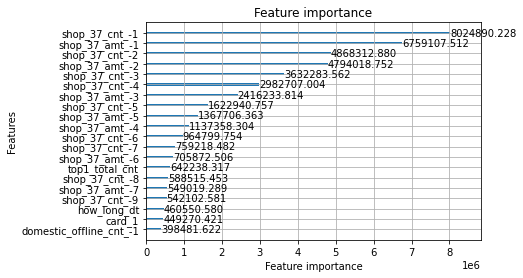

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.122427	valid_1's l2: 0.118917
[100]	training's l2: 0.117811	valid_1's l2: 0.115051
[150]	training's l2: 0.113167	valid_1's l2: 0.11143
[200]	training's l2: 0.108852	valid_1's l2: 0.108355
[250]	training's l2: 0.105056	valid_1's l2: 0.105968
[300]	training's l2: 0.101915	valid_1's l2: 0.104339
[350]	training's l2: 0.0993563	valid_1's l2: 0.103312
[400]	training's l2: 0.0971767	valid_1's l2: 0.102675
[450]	training's l2: 0.095319	valid_1's l2: 0.102305
[500]	training's l2: 0.0935274	valid_1's l2: 0.102051
[550]	training's l2: 0.091885	valid_1's l2: 0.101905
[600]	training's l2: 0.0903082	valid_1's l2: 0.101842
[650]	training's l2: 0.0889592	valid_1's l2: 0.10182
[700]	training's l2: 0.0876485	valid_1's l2: 0.101869
[750]	training's l2: 0.0864218	valid_1's l2: 0.10191
Early stopping, best iteration is:
[652]	training's l2: 0.0889099	valid_1's l2: 0.101812


<Figure size 864x432 with 0 Axes>

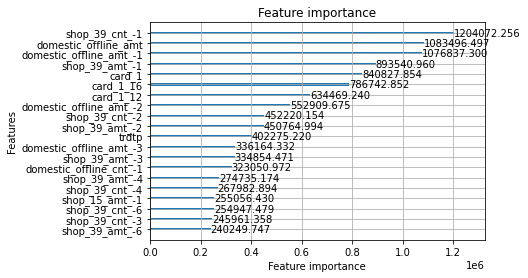

Training until validation scores don't improve for 100 rounds
[50]	training's l2: 2.18555	valid_1's l2: 1.9963
[100]	training's l2: 1.94349	valid_1's l2: 1.77243
[150]	training's l2: 1.69431	valid_1's l2: 1.54901
[200]	training's l2: 1.46663	valid_1's l2: 1.35212
[250]	training's l2: 1.28616	valid_1's l2: 1.20289
[300]	training's l2: 1.16699	valid_1's l2: 1.11141
[350]	training's l2: 1.08397	valid_1's l2: 1.05346
[400]	training's l2: 1.02947	valid_1's l2: 1.0204
[450]	training's l2: 0.988396	valid_1's l2: 0.999386
[500]	training's l2: 0.958714	valid_1's l2: 0.989027
[550]	training's l2: 0.933504	valid_1's l2: 0.981913
[600]	training's l2: 0.907957	valid_1's l2: 0.975012
[650]	training's l2: 0.888819	valid_1's l2: 0.970824
[700]	training's l2: 0.869447	valid_1's l2: 0.967858
[750]	training's l2: 0.851176	valid_1's l2: 0.965135
[800]	training's l2: 0.837163	valid_1's l2: 0.96413
[850]	training's l2: 0.821582	valid_1's l2: 0.962702
[900]	training's l2: 0.807705	valid_1's l2: 0.961732
[950

<Figure size 864x432 with 0 Axes>

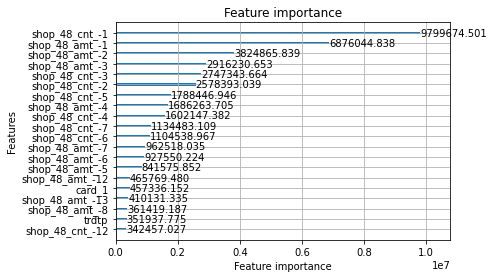

In [27]:
results = {a_cate: [] for a_cate in cnt_handler.ylabels}
train_results = {a_cate: [] for a_cate in cnt_handler.ylabels}

for fold, (trn_ind, val_ind) in enumerate(idx_results):
    print(f'Training fold {fold + 1}')
    for ylabel in cnt_handler.ylabels:
        col_name = ylabel

        X_train, X_val = X.iloc[trn_ind].copy(), X.iloc[val_ind].copy()
        y_train, y_val = y.iloc[trn_ind][col_name].copy(
        ), y.iloc[val_ind][col_name].copy()

        train_dataset = lgb.Dataset(
            X_train, y_train, categorical_feature=profile_handler.cate_feats)
        val_dataset = lgb.Dataset(
            X_val, y_val, categorical_feature=profile_handler.cate_feats)

        model = lgb.train(
            params=params,
            train_set=train_dataset,
            valid_sets=[train_dataset, val_dataset],
            num_boost_round=2000,
            early_stopping_rounds=100,
            verbose_eval=50,
        )

        val_preds = pd.DataFrame(model.predict(X_val))
        train_results[ylabel].append(val_preds)
        plt.figure(figsize=(12, 6))
        lgb.plot_importance(model, max_num_features=20, importance_type='gain')
        plt.title("Feature importance")
        plt.show()
        result = pd.DataFrame(model.predict(cnt_test))
        results[ylabel].append(result)

In [28]:
loader.save_data([results, train_results, idx_results],
                 '2021_12_24_cnt_v_train_results.joblib',
                 'generate cnt_v train results')
